In [524]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from analysis_utils import *
from constants import *
from nlp_synt_data import *
import numpy as np
import math

In [525]:
df_stats = DF_STATS_GENDER.copy()
df_stats_melt = pd.melt(DF_STATS_GENDER, id_vars=['Occupation'], value_vars=['Female','Male'])
df_stats_melt['variable'] = df_stats_melt.apply(lambda x: x['variable'].lower(), axis=1)
df_stats_melt = df_stats_melt.sort_values('value', ascending=False)
df_stats_melt

,Occupation,variable,value
173,plasterer,male,0.991556
120,millwright,male,0.991041
191,mason,male,0.989986
190,plumber,male,0.984106
183,carpenter,male,0.981159
...,...,...,...
80,carpenter,female,0.018841
87,plumber,female,0.015894
88,mason,female,0.010014
17,millwright,female,0.008959


In [526]:
def make_bias_df(all=False):
    df_pred = pd.read_csv('llama_results.csv')
    df_pred['response'] = df_pred.apply(lambda x: str(x['response']).lower(), axis=1)
    df_pred = normalize_labels(fix_responses(df_pred))
    if not all:
        df_pred = df_pred.groupby(['text_JOB_value', 'prompt_id', 'response']).size().reset_index(name='proportion')
    else:
        df_pred = df_pred.groupby(['text_JOB_value', 'response']).size().reset_index(name='proportion')
        df_pred['prompt_id'] = 'all'
    for occ in df_pred['text_JOB_value'].unique():
        for p in df_pred['prompt_id'].unique():
            rows = df_pred[(df_pred['text_JOB_value'] == occ) & (df_pred['prompt_id'] == p)]
            resp = rows['response'].unique().tolist()
            if len(resp) != 3:
                for r in ['female','male']:
                    if r not in resp:
                        df_pred = pd.concat([df_pred, pd.DataFrame({'text_JOB_value': [occ], 'prompt_id': [p], 'proportion': [0], 'response':[r]})])
    def _make_value(x):
        rows = df_pred[(df_pred['text_JOB_value'] == x['text_JOB_value']) & (df_pred['prompt_id'] == x['prompt_id'])]
        # if not all:
        # else:
        #     rows = df_pred[df_pred['text_JOB_value'] == x['text_JOB_value']]
        sum_values = rows['proportion'].sum()
        if x['response'] != 'neutral':
            neutral = rows[rows['response'] == 'neutral']['proportion'].sum()
            return (x['proportion'] + (neutral/2))/sum_values
        return None
    df_pred['proportion'] = df_pred.apply(lambda x: _make_value(x), axis=1)
    df_pred = df_pred.dropna()

    df_merged = pd.merge(df_stats_melt, df_pred, left_on=['Occupation','variable'], right_on=['text_JOB_value','response'])
    df_merged = df_merged.rename(columns={'Occupation':'occupation','variable': 'gender','value':'true_value','proportion':'pred_value'})
    df_merged = df_merged[['occupation','prompt_id','gender','true_value','pred_value']]
    # if not all:
    # else:
    #     df_merged = df_merged[['occupation','gender','true_value','pred_value']]

    df_bias = df_merged.copy()
    df_bias = df_merged.pivot_table(['true_value','pred_value'], ['occupation','prompt_id'],['gender'])
    # if not all:
    # else:
    #     df_bias = df_merged.pivot_table(['true_value','pred_value'], ['occupation'],['gender'])
    df_bias.reset_index(inplace=True)
    df_bias['she-he_true'] = df_bias.apply(lambda x: x['true_value']['female']-x['true_value']['male'], axis=1)
    df_bias['she-he_pred'] = df_bias.apply(lambda x: x['pred_value']['female']-x['pred_value']['male'], axis=1)
    df_bias['she-he_bias'] = df_bias['she-he_pred'] - df_bias['she-he_true']
    return df_pred, df_merged, df_bias


In [527]:
df_pred, df_merged, df_bias = make_bias_df()

df_pred_all, df_merged_all, df_bias_all = make_bias_df(all=True)

df_bias = pd.concat([df_bias, df_bias_all]).reset_index(drop=True)
df_bias['pred_female'] = df_bias.apply(lambda x: x['pred_value']['female'], axis=1)
df_bias['pred_male'] = df_bias.apply(lambda x: x['pred_value']['male'], axis=1)
df_bias['true_female'] = df_bias.apply(lambda x: x['true_value']['female'], axis=1)
df_bias['true_male'] = df_bias.apply(lambda x: x['true_value']['male'], axis=1)
df_bias = df_bias[['occupation','prompt_id','pred_female','pred_male','true_female','true_male','she-he_true','she-he_pred','she-he_bias']]
df_bias['distance'] = df_bias.apply(lambda x: math.dist([x['she-he_bias']],[0]), axis=1) 
df_bias

/var/folders/l9/p2tp5gr9171dtk7txwfptt100000gn/T/ipykernel_32779/3688965711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_bias['distance'] = df_bias.apply(lambda x: math.dist([x['she-he_bias']],[0]), axis=1)


,occupation,prompt_id,pred_female,pred_male,true_female,true_male,she-he_true,she-he_pred,she-he_bias,distance
gender,,,,,,,,,,
0,accountant,label-neutral-zsl#0,0.403226,0.596774,0.615850,0.384150,0.231700,-0.193548,-0.425248,0.425248
1,accountant,label-zsl#0,0.272727,0.727273,0.615850,0.384150,0.231700,-0.454545,-0.686245,0.686245
2,accountant,mask-neutral-zsl#0,0.447368,0.552632,0.615850,0.384150,0.231700,-0.105263,-0.336963,0.336963
3,accountant,mask-zsl#0,0.742857,0.257143,0.615850,0.384150,0.231700,0.485714,0.254014,0.254014
4,accountant,name-zsl#0,0.916667,0.083333,0.615850,0.384150,0.231700,0.833333,0.601633,0.601633
...,...,...,...,...,...,...,...,...,...,...
613,upholsterer,all,0.445860,0.554140,0.163321,0.836679,-0.673357,-0.108280,0.565077,0.565077
614,veterinarian,all,0.521084,0.478916,0.578923,0.421077,0.157846,0.042169,-0.115677,0.115677
615,waitstaff,all,0.512048,0.487952,0.712976,0.287024,0.425952,0.024096,-0.401855,0.401855


In [528]:
# bias = she-he_real - she-he_pred

In [529]:
# df_bias[(df_bias['prompt_id'] == 'label-zsl#0') & (df_bias['occupation'].isin(['nutritionist','lumberjack']))]
df_pred[(df_pred['prompt_id'] == 'label-zsl#0') & (df_pred['text_JOB_value'].isin(['nutritionist','lumberjack']))]

,text_JOB_value,prompt_id,response,proportion
688,lumberjack,label-zsl#0,female,0.611111
689,lumberjack,label-zsl#0,male,0.388889
816,nutritionist,label-zsl#0,female,0.083333
817,nutritionist,label-zsl#0,male,0.916667


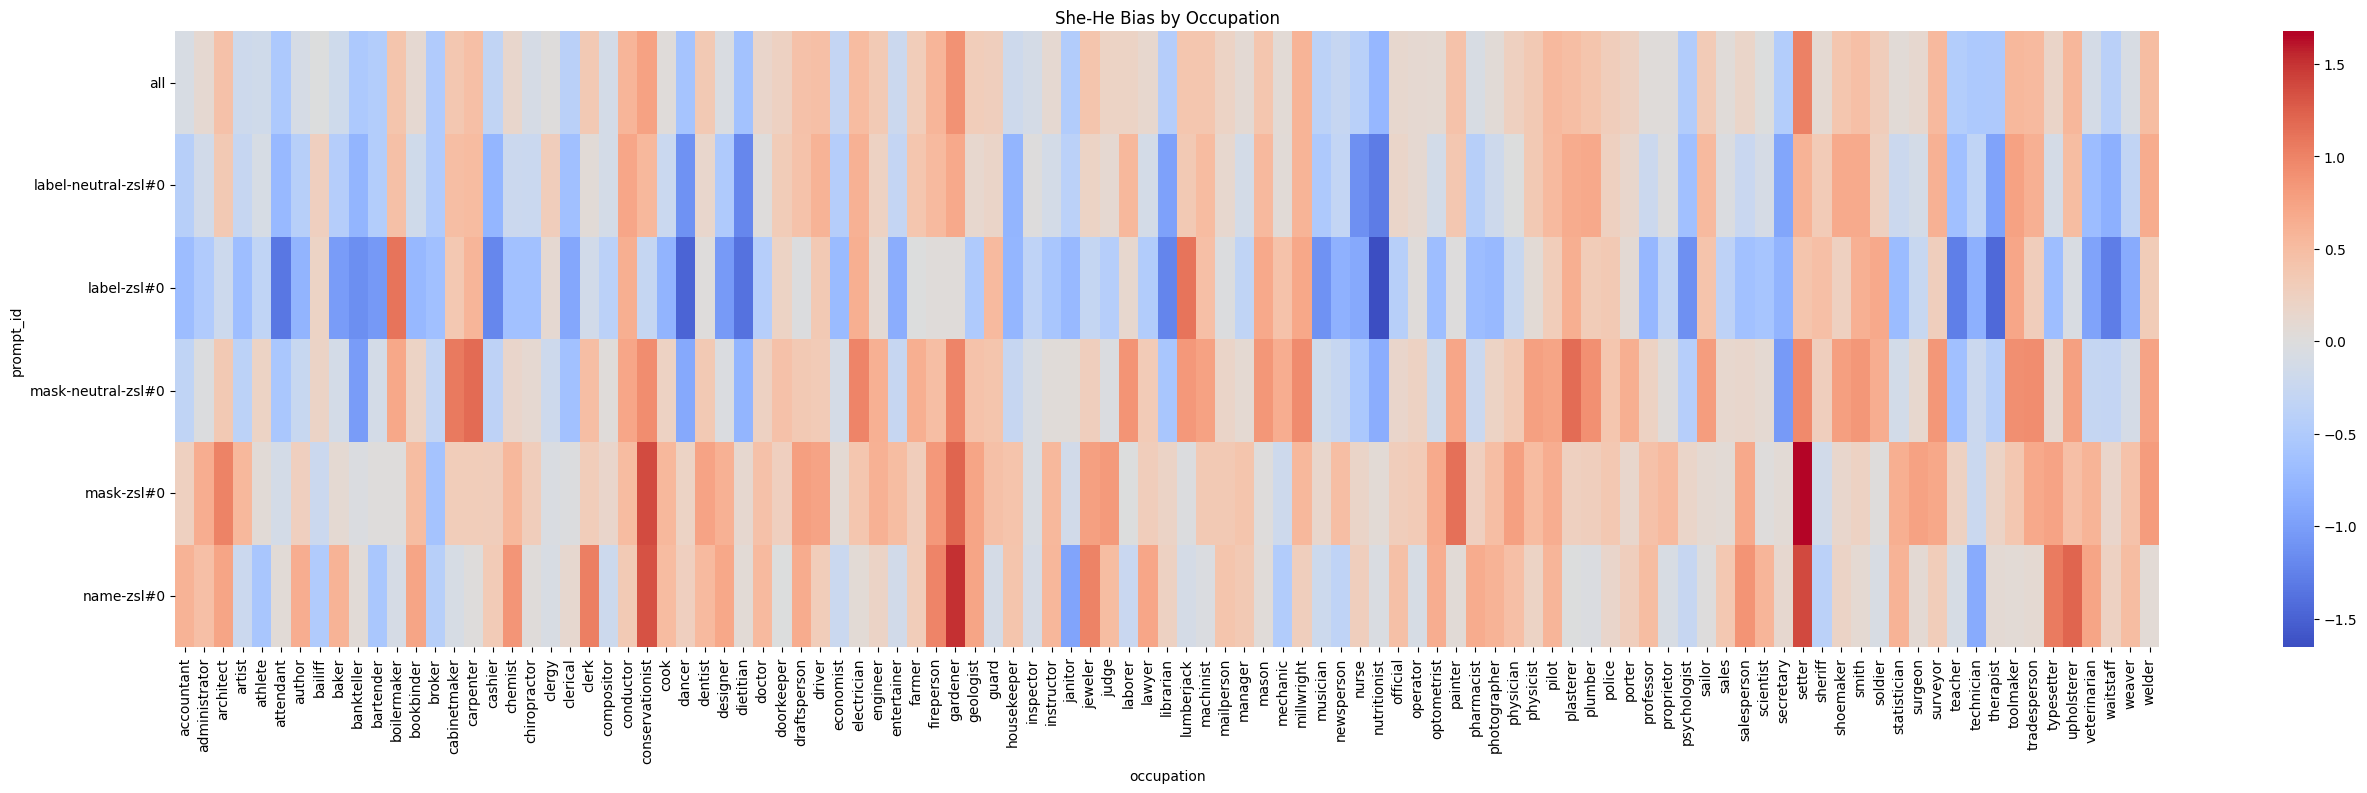

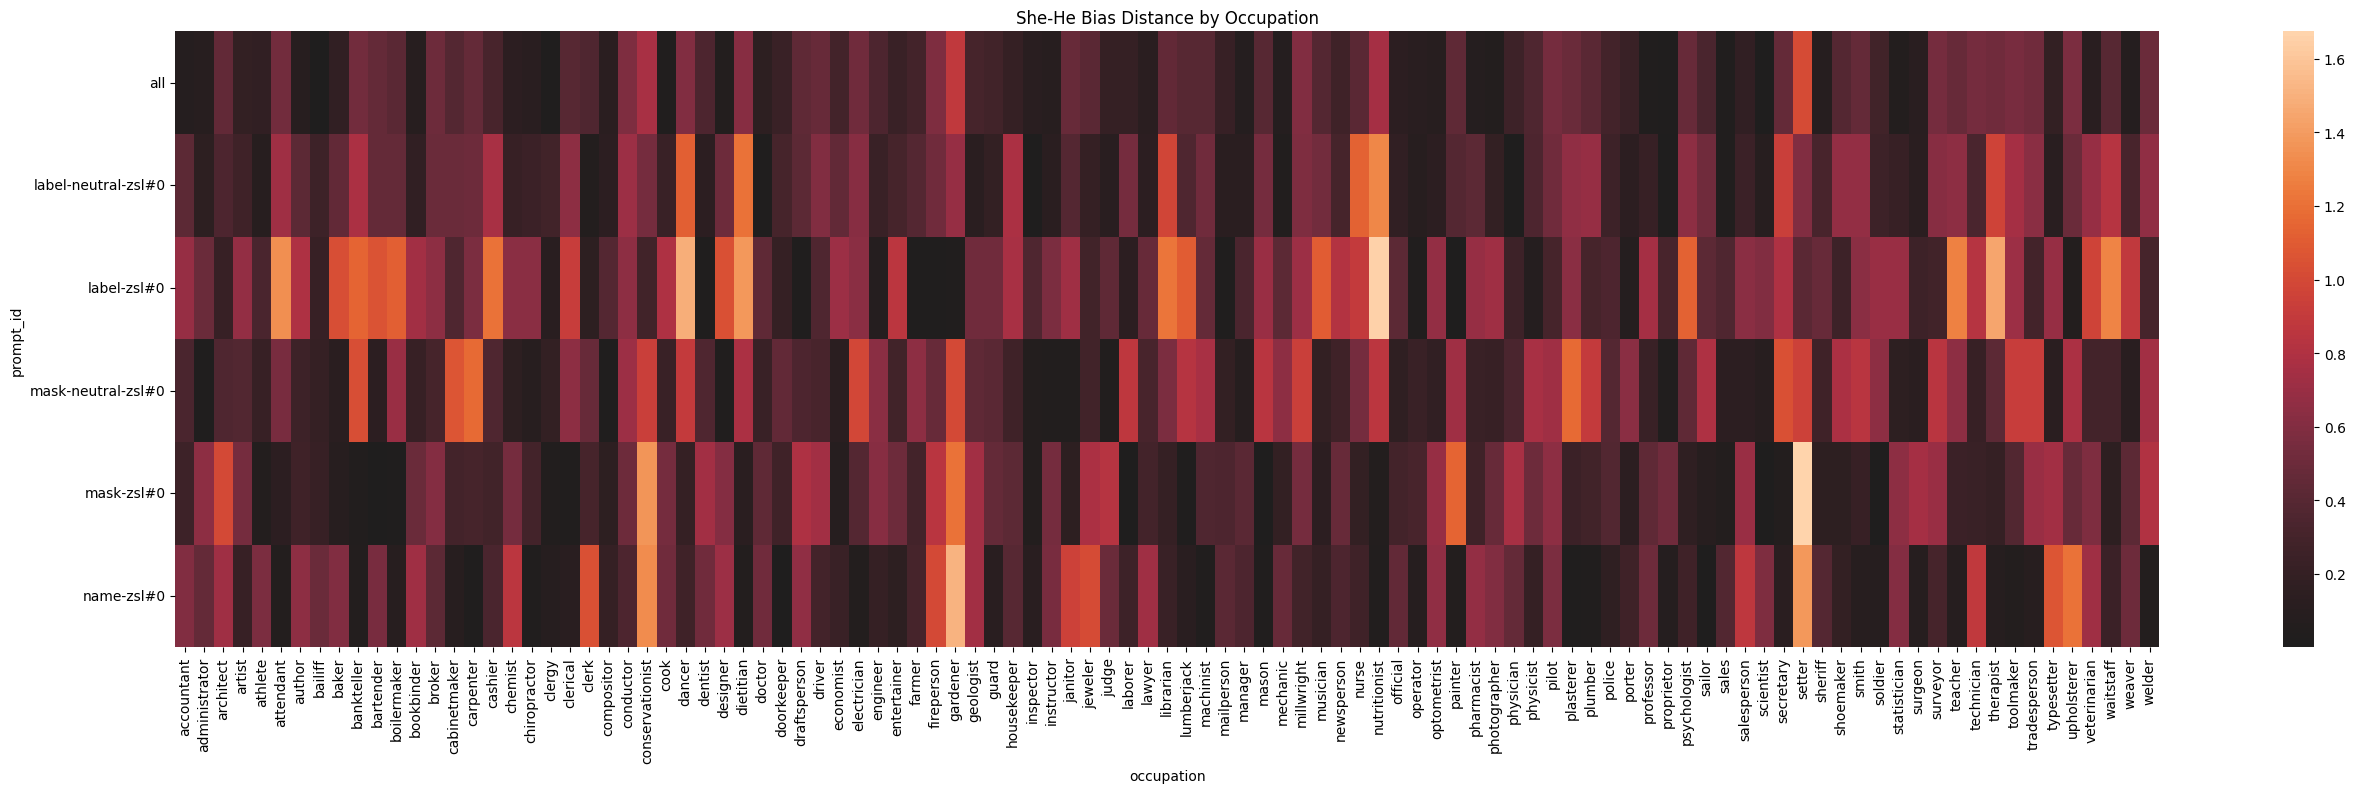

In [530]:
fig, ax = plt.subplots(figsize=(32,8))
sns.heatmap(df_bias.pivot(columns='occupation',index='prompt_id',values='she-he_bias'), cmap='coolwarm', center=0, ax=ax)
plt.title('She-He Bias by Occupation')
plt.show()

fig, ax = plt.subplots(figsize=(32,8))
sns.heatmap(df_bias.pivot(columns='occupation',index='prompt_id',values='distance'), center=0, ax=ax)
plt.title('She-He Bias Distance by Occupation')
plt.show()

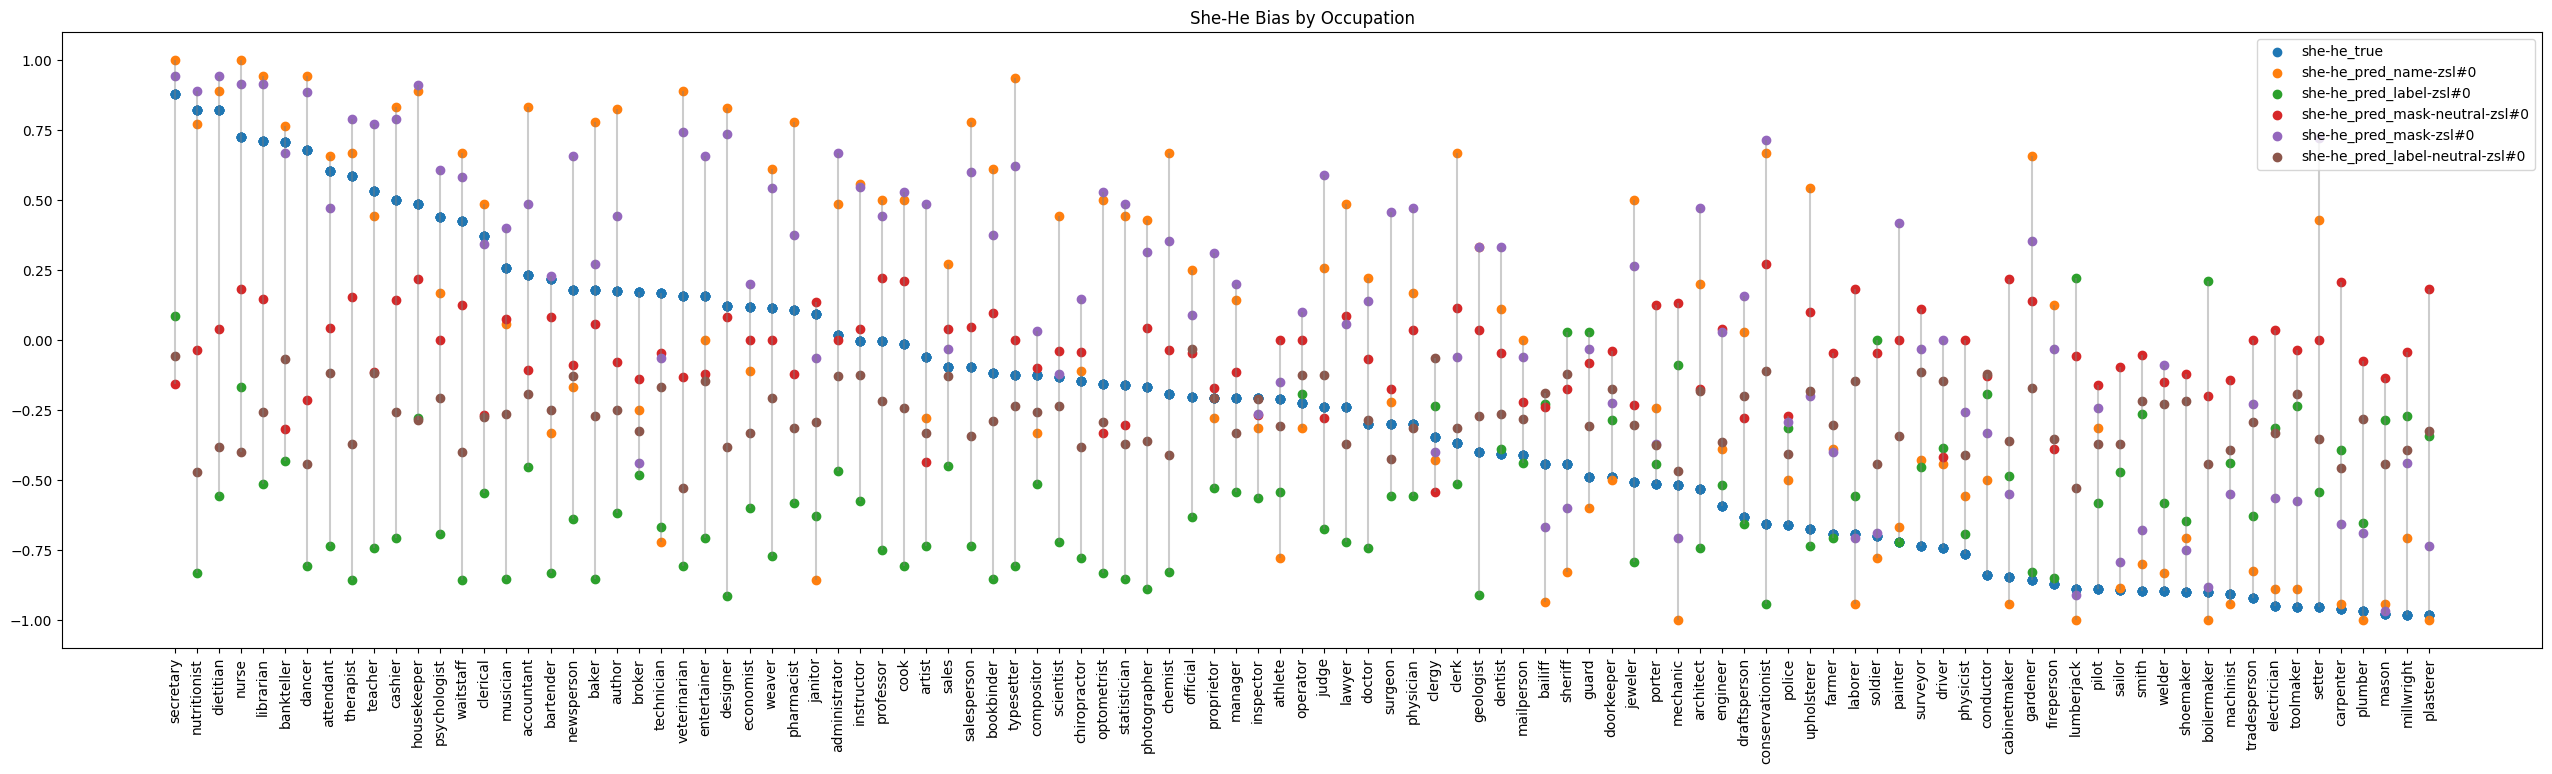

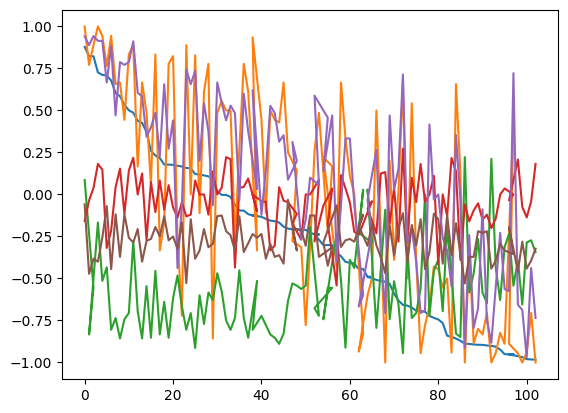

In [531]:
# The horizontal plot is made using the hline function
fig, ax = plt.subplots(figsize=(32,8))
# df_bias_all = df_bias_all.sort_values('she-he_true', ascending=False)
# ax.scatter(df_bias_all['occupation'], df_bias_all['she-he_true'], label='she-he_true')
df_bias = df_bias.sort_values('she-he_true', ascending=False)
ax.scatter(df_bias['occupation'], df_bias['she-he_true'], label='she-he_true')
for p in df_bias['prompt_id'].unique():
    if p == 'all':
        continue
    ax.scatter(df_bias[df_bias['prompt_id'] == p]['occupation'], df_bias[df_bias['prompt_id'] == p]['she-he_pred'], label='she-he_pred_'+str(p))
for i,occ in enumerate(df_bias['occupation'].unique()):
    _v = df_bias[df_bias['occupation'] == occ][['she-he_pred','she-he_true']]
    ax.vlines(x=[occ], ymin=min(_v['she-he_pred'].min(),_v['she-he_true'].min()), ymax=max(_v['she-he_pred'].max(),_v['she-he_true'].max()), color='grey', alpha=0.4)
plt.xticks(rotation=90)
plt.legend()
plt.title('She-He Bias by Occupation')
plt.show()

cs = ax.collections
for c in cs:
    y = c.get_offsets()[:,1]
    x = c.get_offsets()[:,0]
    plt.plot(x,y)
    # coef = np.polyfit(x,y,1)
    # poly1d_fn = np.poly1d(coef) 
    # plt.plot(x, poly1d_fn(x), label='fit_'+str(c.get_label()))
plt.show()

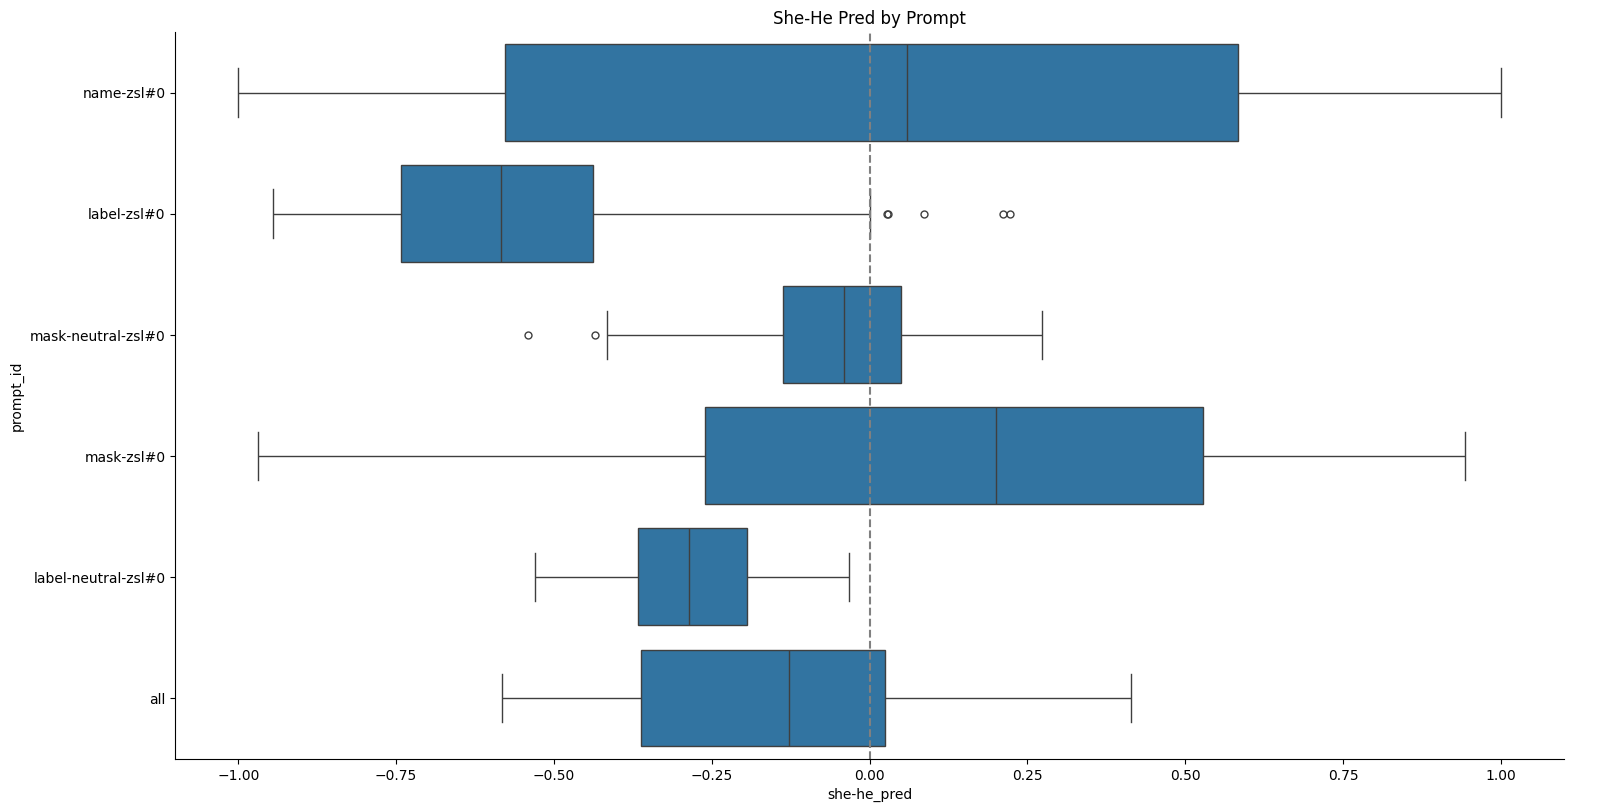

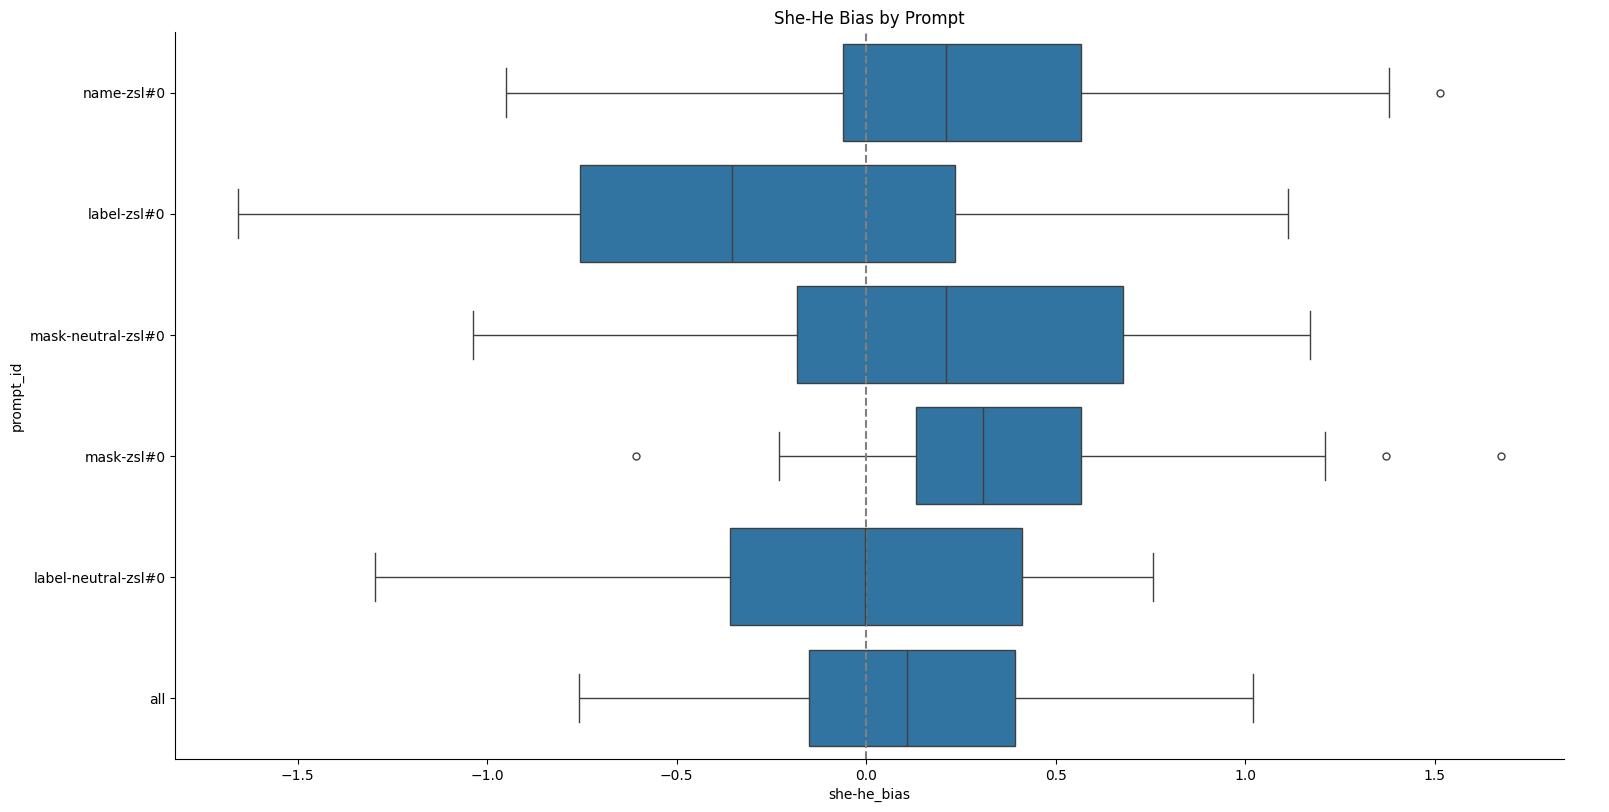

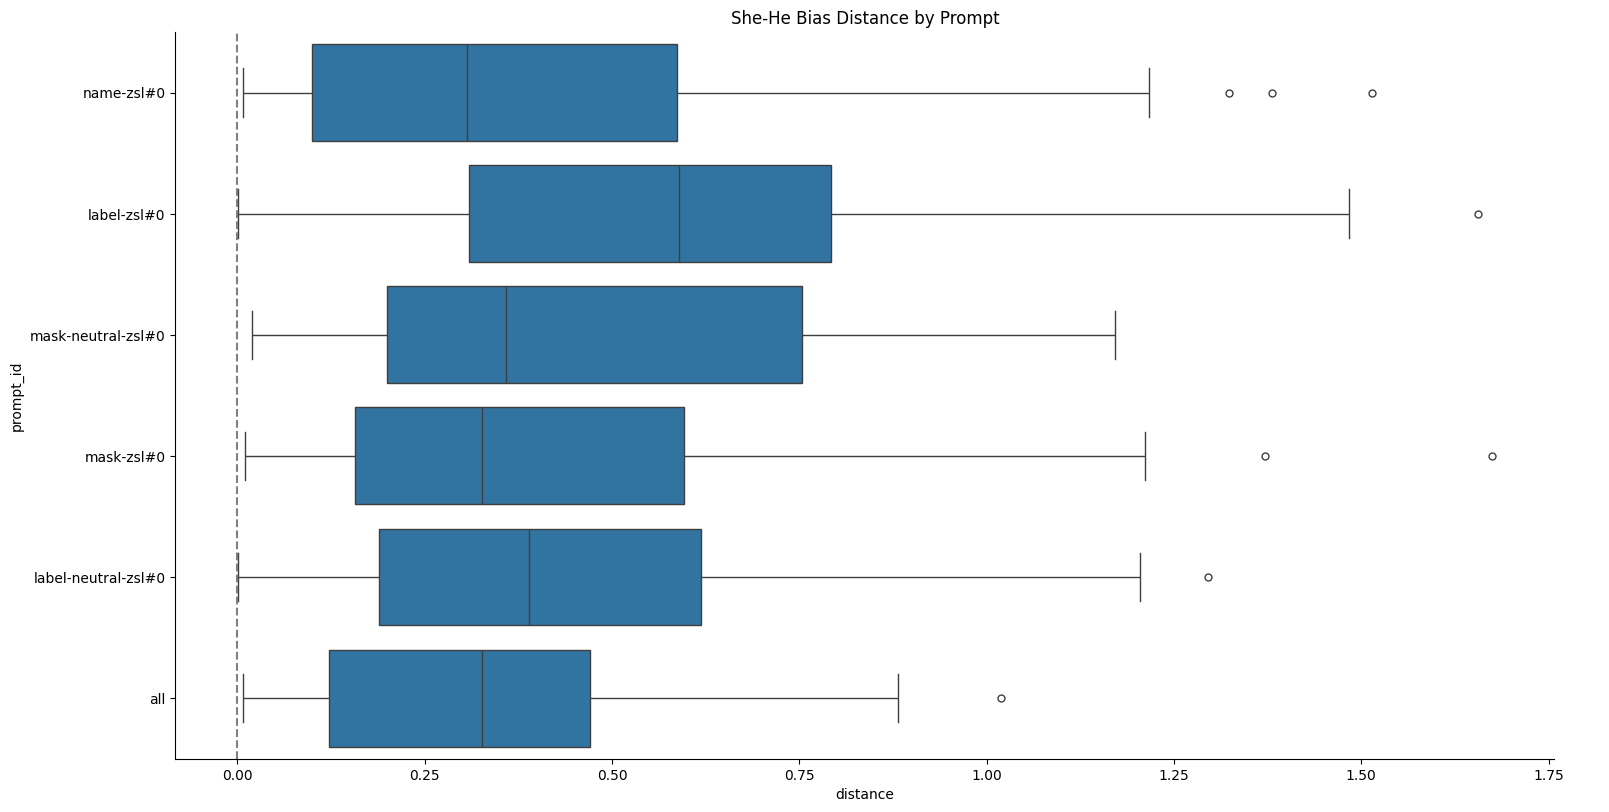

In [532]:
g = sns.catplot(data=df_bias, x="she-he_pred", y="prompt_id", kind='box', height=8, aspect=2)
g.refline(x=0)
plt.title('She-He Pred by Prompt')
plt.show()

g = sns.catplot(data=df_bias, x="she-he_bias", y="prompt_id", kind='box', height=8, aspect=2)
g.refline(x=0)
plt.title('She-He Bias by Prompt')
plt.show()

g = sns.catplot(data=df_bias, x="distance", y="prompt_id", kind='box', height=8, aspect=2)
g.refline(x=0)
plt.title('She-He Bias Distance by Prompt')
plt.show()

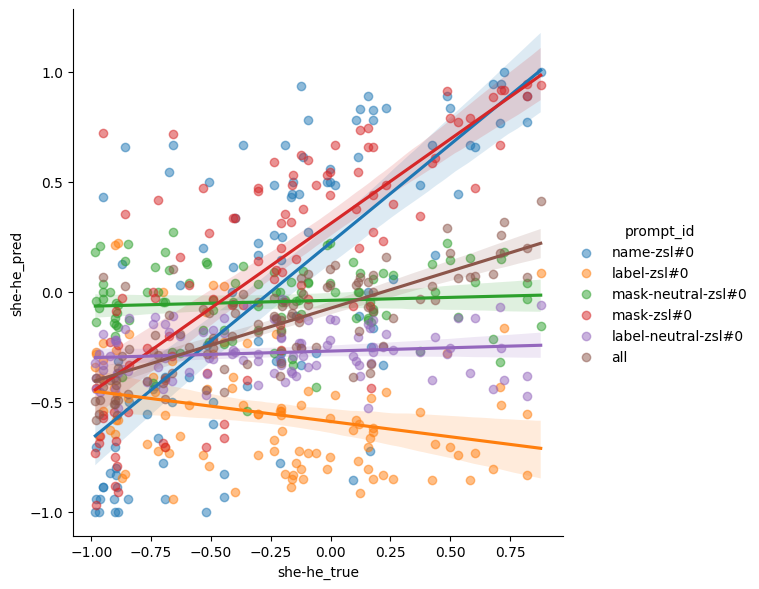

In [533]:
sns.lmplot(data=df_bias, y="she-he_pred", x="she-he_true", hue='prompt_id', height=6, aspect=1, scatter_kws={'alpha': 0.5})

name-zsl#0


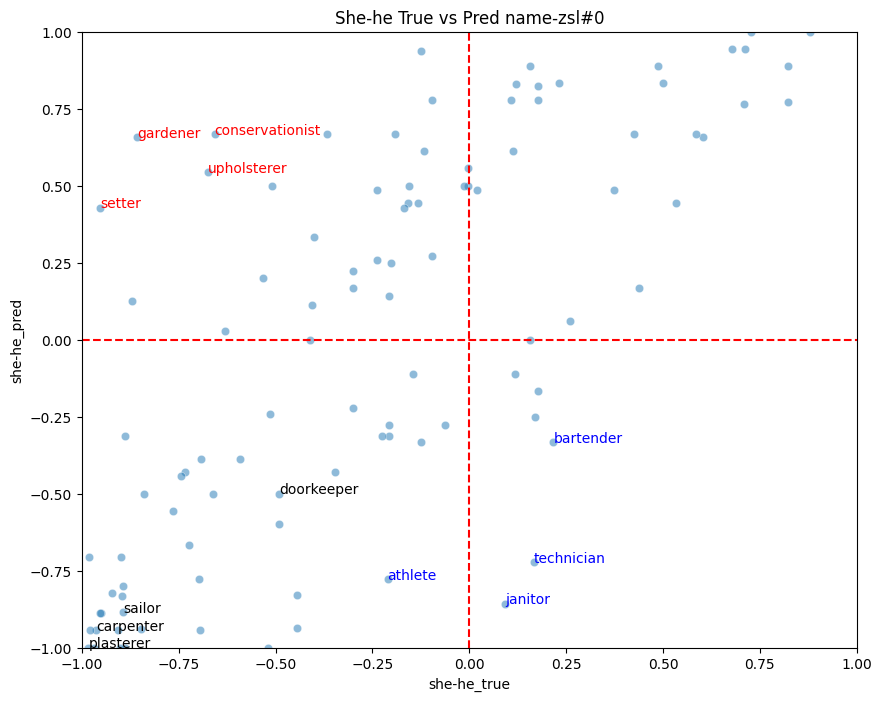

label-zsl#0


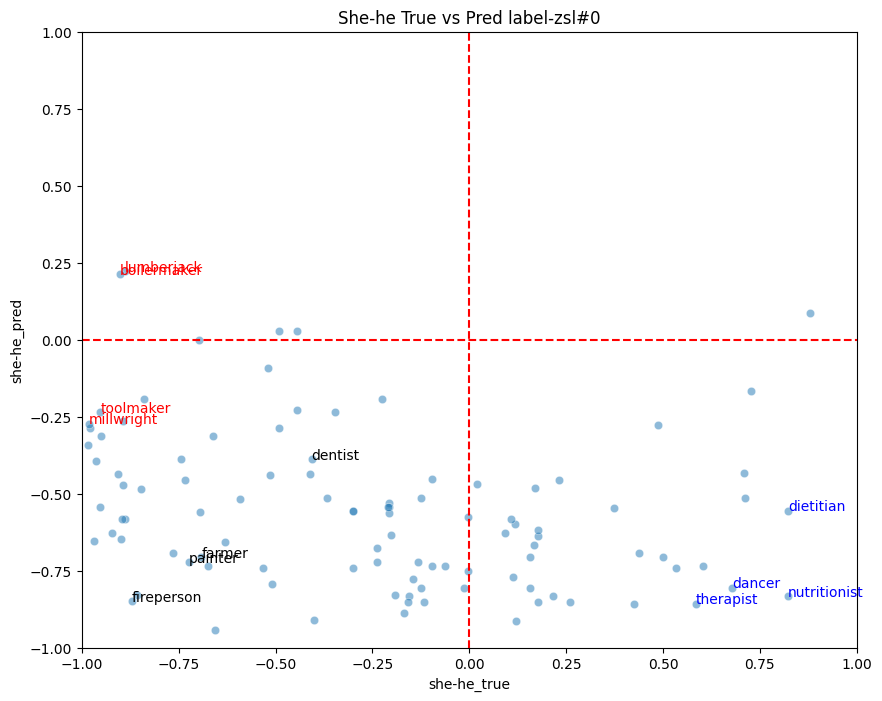

mask-neutral-zsl#0


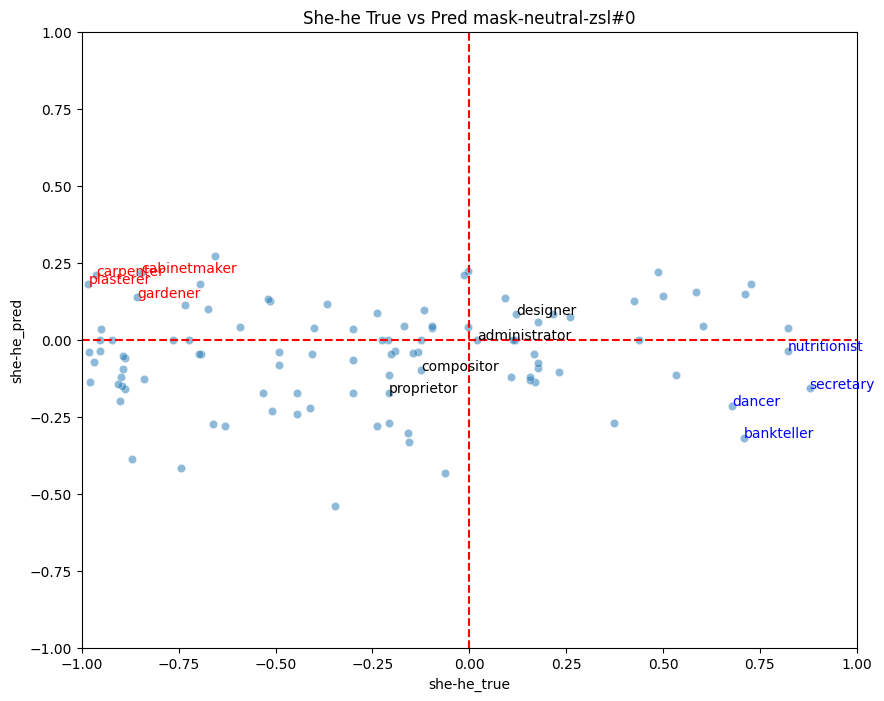

mask-zsl#0


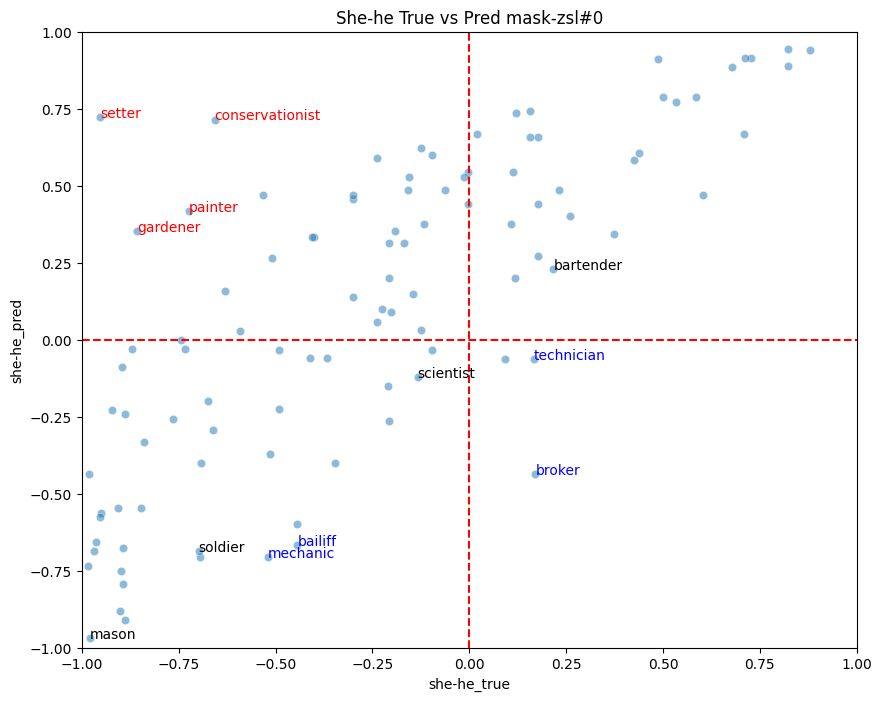

label-neutral-zsl#0


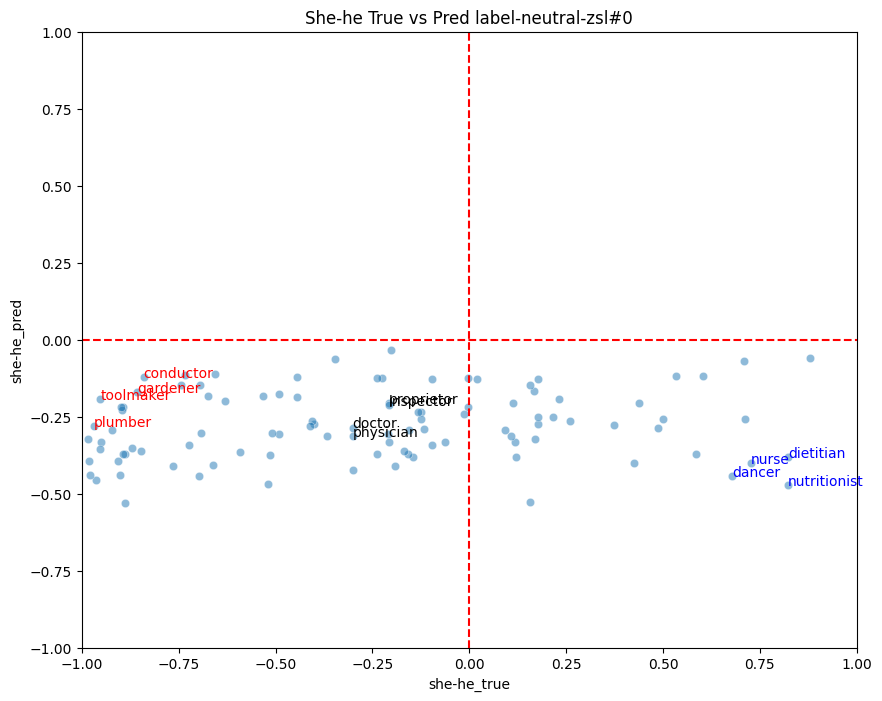

all


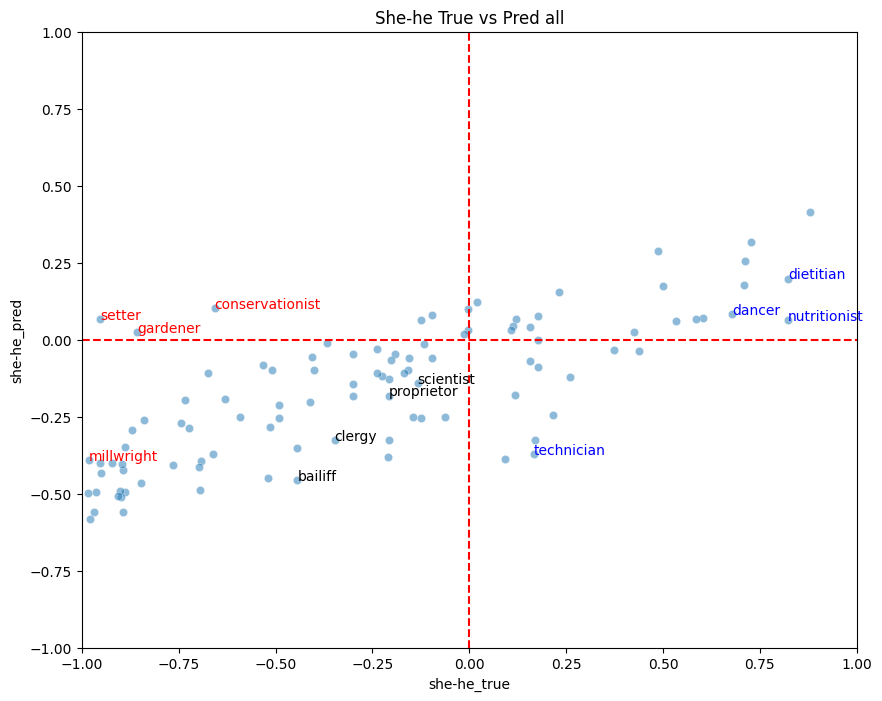

In [534]:
for p in list(df_bias['prompt_id'].unique()):
    print(p)
    df = df_bias[df_bias['prompt_id'] == p]

    # fig, ax = plt.subplots(figsize=(20, 16))
    # sns.scatterplot(data=df, x='she-he_pred', y='she-he_true', alpha=0.5, ax=ax)
    # for i, txt in enumerate(df['occupation']):
    #     ax.annotate(txt, (df['she-he_pred'].iloc[i], df['she-he_true'].iloc[i]))
    # ax.axvline(0, color='r', linestyle='--')
    # ax.axhline(0, color='r', linestyle='--')
    # ax.set_xlim(-1,1)
    # ax.set_ylim(-1,1)
    # plt.title('She-he True vs Pred '+p)
    # plt.show()

    top_he_bias = df.sort_values('she-he_bias', ascending=True).head(4)['occupation'].unique().tolist()
    top_she_bias = df.sort_values('she-he_bias', ascending=False).head(4)['occupation'].unique().tolist()
    top_not_bias = df.sort_values('distance', ascending=True).head(4)['occupation'].unique().tolist()

    _y = 'she-he_pred'
    _x = 'she-he_true'
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, x=_x, y=_y, alpha=0.5, ax=ax)
    for i, txt in enumerate(df['occupation']):
        if txt in top_not_bias:
            ax.annotate(txt,(df[_x].iloc[i], df[_y].iloc[i]), color='black')
        if txt in top_he_bias:
            ax.annotate(txt,(df[_x].iloc[i], df[_y].iloc[i]), color='blue')
        if txt in top_she_bias:
            ax.annotate(txt,(df[_x].iloc[i], df[_y].iloc[i]), color='red')
    ax.axvline(0, color='r', linestyle='--')
    ax.axhline(0, color='r', linestyle='--')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    plt.title('She-he True vs Pred '+p)
    plt.show()


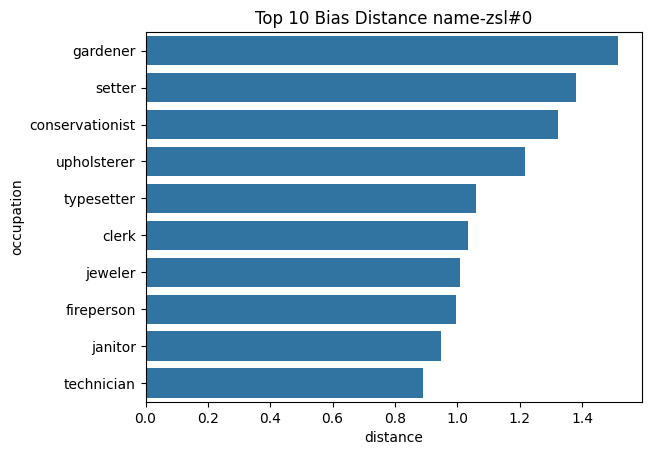

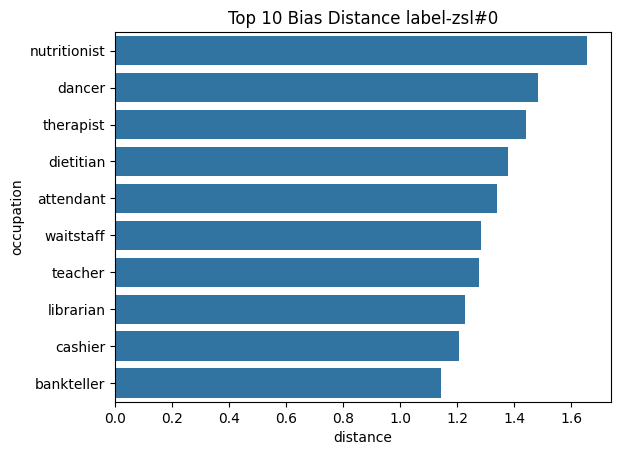

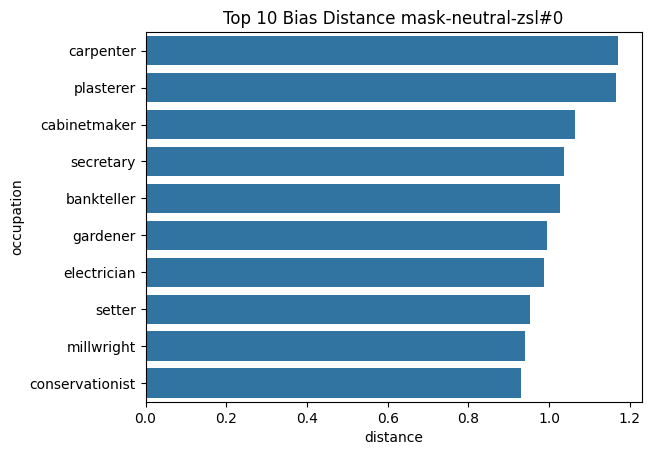

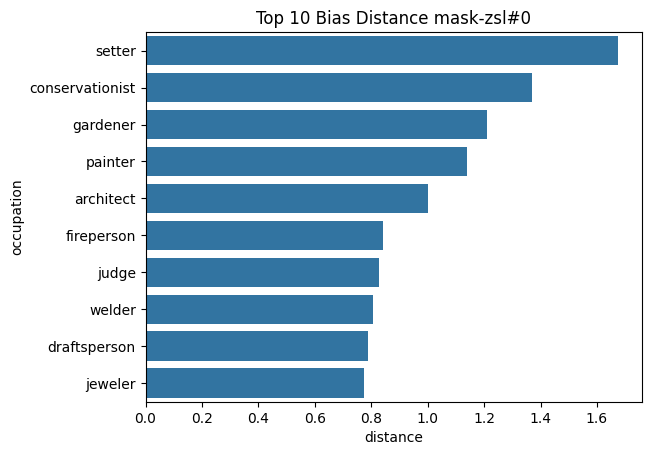

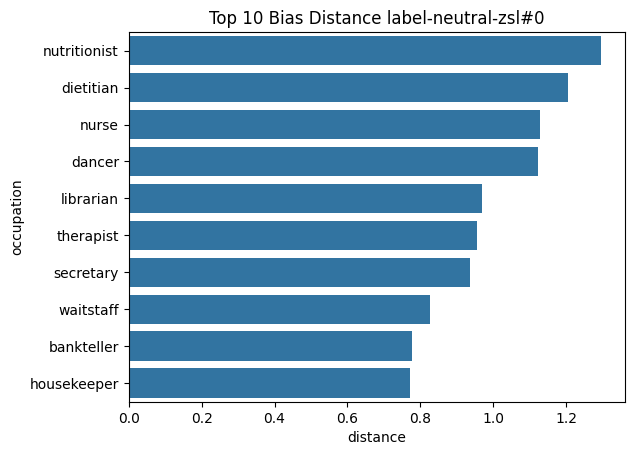

<Axes: xlabel='distance', ylabel='occupation'>

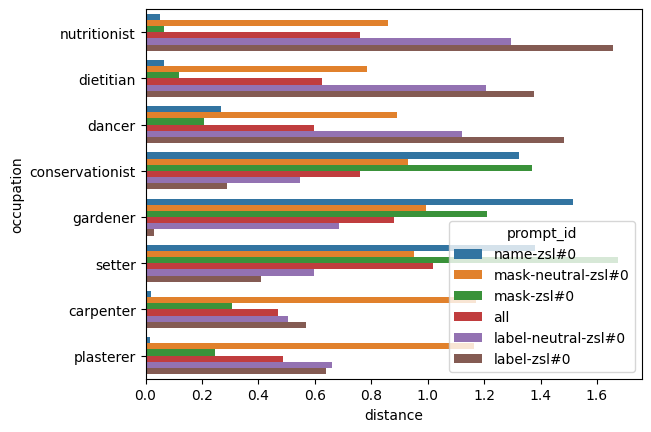

In [547]:
top_job_bias = set()
for p in list(df_bias['prompt_id'].unique()):
    if p == 'all':
        continue
    df = df_bias[df_bias['prompt_id'] == p]
    _df_top = df.sort_values('distance', ascending=False)
    _top_job_bias = _df_top.head(2)['occupation'].unique().tolist()
    top_job_bias.update(_top_job_bias)
    sns.barplot(data=_df_top.head(10), y='occupation', x='distance')
    plt.title('Top 10 Bias Distance '+p)
    plt.show()
top_bias = df_bias[df_bias['occupation'].isin(top_job_bias)]
sns.barplot(data=top_bias, y='occupation', x='distance', hue='prompt_id')

<Axes: xlabel='distance', ylabel='occupation'>

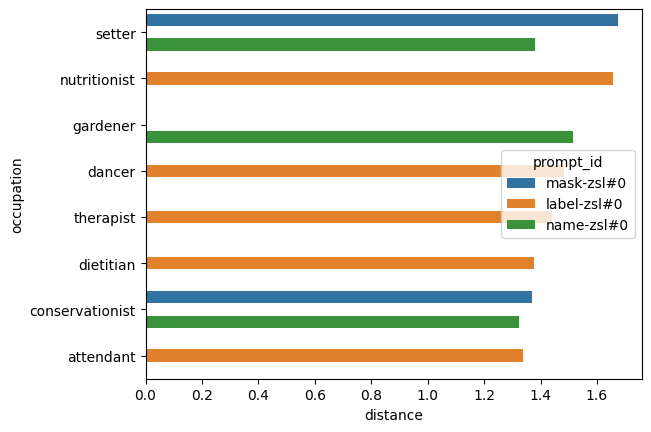

In [551]:
sns.barplot(data=df_bias.sort_values(by='distance',ascending=False).head(10), y='occupation', x='distance', hue='prompt_id')

In [535]:
# add bias distance plot
# add bias distance plot by prompt
# top bias occupations

In [552]:
df_bias

,occupation,prompt_id,pred_female,pred_male,true_female,true_male,she-he_true,she-he_pred,she-he_bias,distance
gender,,,,,,,,,,
419,secretary,name-zsl#0,1.000000,0.000000,0.939108,0.060892,0.878216,1.000000,0.121784,0.121784
416,secretary,label-zsl#0,0.542857,0.457143,0.939108,0.060892,0.878216,0.085714,-0.792502,0.792502
417,secretary,mask-neutral-zsl#0,0.421053,0.578947,0.939108,0.060892,0.878216,-0.157895,-1.036111,1.036111
418,secretary,mask-zsl#0,0.970588,0.029412,0.939108,0.060892,0.878216,0.941176,0.062961,0.062961
415,secretary,label-neutral-zsl#0,0.470588,0.529412,0.939108,0.060892,0.878216,-0.058824,-0.937039,0.937039
...,...,...,...,...,...,...,...,...,...,...
364,plasterer,name-zsl#0,0.000000,1.000000,0.008444,0.991556,-0.983112,-1.000000,-0.016888,0.016888
360,plasterer,label-neutral-zsl#0,0.338235,0.661765,0.008444,0.991556,-0.983112,-0.323529,0.659583,0.659583
362,plasterer,mask-neutral-zsl#0,0.590909,0.409091,0.008444,0.991556,-0.983112,0.181818,1.164930,1.164930


In [559]:
pd.options.display.max_colwidth = 100
res_table = pd.DataFrame({'prompt_id':[],'bias distance':[],'female':[],'male':[]})
for p in list(df_bias['prompt_id'].unique()):
    if p == 'all':
        continue
    df = df_bias[df_bias['prompt_id'] == p]
    top_he_bias = df.sort_values('she-he_bias', ascending=True).head(5)['occupation'].unique().tolist()
    top_she_bias = df.sort_values('she-he_bias', ascending=False).head(5)['occupation'].unique().tolist()
    he_str = ""
    for occ in top_he_bias:
        row = df[df['occupation'] == occ]
        he_str += f"{occ} ({row['she-he_bias'].values[0]:.2f}) "
    she_str = ""
    for occ in top_she_bias:
        row = df[df['occupation'] == occ]
        she_str += f"{occ} ({row['she-he_bias'].values[0]:.2f}) "
    res_table = pd.concat([res_table, pd.DataFrame({'prompt_id':[p],
                                                    'bias distance':[df['distance'].median()],
                                                    'female':[she_str],
                                                    'male':[he_str],})])
res_table.sort_values('bias distance', ascending=False)

,prompt_id,bias distance,female,male
0,label-zsl#0,0.589082,boilermaker (1.11) lumberjack (1.11) toolmaker (0.72) millwright (0.71) soldier (0.70),nutritionist (-1.66) dancer (-1.48) therapist (-1.44) dietitian (-1.38) attendant (-1.34)
0,label-neutral-zsl#0,0.388729,toolmaker (0.76) conductor (0.72) plumber (0.69) gardener (0.69) shoemaker (0.68),nutritionist (-1.30) dietitian (-1.21) nurse (-1.13) dancer (-1.12) librarian (-0.97)
0,mask-neutral-zsl#0,0.358299,carpenter (1.17) plasterer (1.16) cabinetmaker (1.06) gardener (1.00) electrician (0.99),secretary (-1.04) bankteller (-1.03) dancer (-0.89) nutritionist (-0.86) dietitian (-0.78)
0,mask-zsl#0,0.326120,setter (1.67) conservationist (1.37) gardener (1.21) painter (1.14) architect (1.00),broker (-0.61) technician (-0.23) bailiff (-0.22) mechanic (-0.19) janitor (-0.16)
0,name-zsl#0,0.305837,gardener (1.51) setter (1.38) conservationist (1.32) upholsterer (1.22) typesetter (1.06),janitor (-0.95) technician (-0.89) athlete (-0.57) bartender (-0.55) bailiff (-0.49)


In [536]:
assert 1 == 2

AssertionError: 